<a href="https://colab.research.google.com/github/milosgalecic/ML/blob/main/milos_galecic_mu_dz1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LASSO Regresija

### Minimizacija kriterijumske funkcije sa LASSO regularizacijom pomocu gradijentnog spusta

Potrebo je minimizovati kriterijumsku funkciju po $\theta$:

$\arg \min_{\theta_0, \dots, \theta_n} \quad \sum_{i=1}^{m} \left( y_i - \theta_0 - \sum_{j=1}^{n} \theta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{n} |\theta_j|$

Diferencijal Kriterijumska funkcija se deli na dva dela. Diferencijal Funkcije gubitka i regularizacionog dela.  
   
     
       
-Funckija gubitka(L) je diferencijabilna i moguce ju je minimizovati gradijentnim spustom.
$$
\frac{\partial L}{\partial \theta_j} = -2\sum_{i=1}^{n} x_{ij} \left( y_i - \sum_{j=1}^{p} \theta_j x_{ij} \right)
$$

$$
= -2\sum_{i=1}^{n} x_{ij} \left( y_i - \sum_{k \neq j} \theta_k x_{ik} - \theta_j x_{ij} \right)
$$

$$
= -2\sum_{i=1}^{n} x_{ij} \left( y_i - \sum_{k \neq j} \theta_k x_{ik} \right) + 2 \theta_j \sum_{i=1}^{n} x_{ij}^2
$$

$$
\rho_j = 2 \sum_{i=1}^{n} x_{ij} \left( y_i - \sum_{k \neq j} \theta_k x_{ik} \right)
$$

$$
z_j = 2 \sum_{i=1}^{n} x_{ij}^2
$$
Funkcija se predstavlja u pojednostavljenom obliku:
$$
\frac{\partial L}{\partial \theta_j}= -\rho_j + \theta_j z_j
$$
-Reguralizacioni deo (L1) deo nije diferencijabilan za $\theta = 0$ . Zato je potrebno podeliti funkciju na delove koji jesu diferencijabilni

$$
\partial_{\theta_j} L_1 = \partial_{\theta_j} \left( \lambda \sum_{j=1}^{n} |\theta_j| \right)
$$

$$
\partial_{\theta_j} \left( \lambda |\theta_j| \right) =
\begin{cases}
- \lambda & \text{if} \ \theta_j < 0 \\
[-\lambda, \lambda] & \text{if} \ \theta_j = 0 \\
\lambda & \text{if} \ \theta_j > 0
\end{cases}
$$

Trazimo ekstremum izjednacavajuci ova dva izvoda sa 0:

$$
0 = -\rho_j + \theta_j z_j + \partial_{\theta_j} \lambda ||\theta_j||
$$
Dobijamo izraz za parametar $\theta$, gde je $S(\rho_j, \lambda)$ soft-treshold funkcija:  

$$
\theta_j =
\begin{cases}
\frac{\rho_j + \lambda}{z_j} & \text{if} \ \rho_j < -\lambda \\
0 & \text{if} \ -\lambda \leq \rho_j \leq \lambda \\
\frac{\rho_j - \lambda}{z_j} & \text{if} \ \rho_j > \lambda
\end{cases}
$$

$$
\theta_j = \frac{1}{z_j} S(\rho_j, \lambda) =
\begin{cases}
\rho_j + \lambda & \text{for} \ \rho_j < -\lambda \\
0 & \text{for} \ -\lambda \leq \rho_j \leq \lambda \\
\rho_j - \lambda & \text{for} \ \rho_j > \lambda
\end{cases}
$$

In [5]:
def gradient_descent_lasso(X, y, alpha, max_iter=1000):
    theta = np.zeros(X.shape[1])
    for iteration in range(max_iter):
      for j in range(X.shape[1]):
        residual = y - X.dot(theta) + X[:, j] * theta[j] # Racunanje ostatka bez uticaja parametra j
        rho = X[:, j].dot(residual)
        theta[j] = soft_threshold(rho, alpha) / np.square(X[:, j]).sum()

    return theta

def soft_threshold(rho, alpha):
    if rho < - alpha:
        return (rho + alpha)
    elif rho >  alpha:
        return (rho - alpha)
    else:
        return 0

def mean_squared_error(X, y, w, w0):
    y_pred = X.dot(w) + w0
    squared_errors = np.square(y - y_pred)
    return np.mean(squared_errors)

def root_mean_squared_error(X, y, w, w0):
    y_pred = X.dot(w) + w0
    root_squared_errors = np.sqrt(np.square(y - y_pred))
    return np.mean(root_squared_errors)

def predict(X, w, w0):
    return np.dot(X, w) + w0


Minimalan MSE: 33.56967544003462
Odabrano alfa: 56.41097435897436
Parametri odabranog modela 33.56967544003462


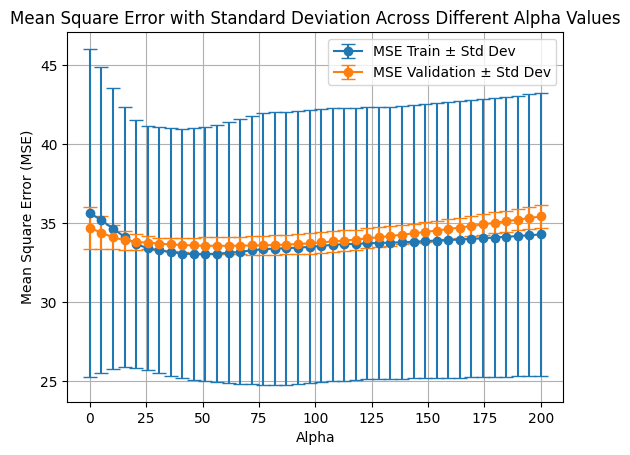

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Priprema podataka
dataframe = read_csv("/content/data-reg.csv", header=None)

validation_data = dataframe.sample(frac=0.3, random_state=4) # 30% podataka za validaciju
training_data = dataframe.drop(validation_data.index)

data_val = validation_data.values
X_val, y_val = data_val[:, :-1], data_val[:, -1]

data = training_data.values
X, y = data[:, :-1], data[:, -1]

# Pretvaranje podataka u polinom drugog reda
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_val_poly = poly.transform(X_val)

# Skaliranje podataka
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_poly)
X_val_standardized = scaler.transform(X_val_poly)

data = np.c_[X_standardized, y]

# Podela podatak za unakrsna validacija sa 5 grupa,
# kako bi se odredilo optimalno alfa (parametar regularizacije)
kf = KFold(n_splits=5)
kf.get_n_splits(data)

MSE_train = [] # Matrica vrednosti srednje kvadrate greske po grupi unakrsne validacije
MSE_val = [] # Matrica vrednosti srednje kvadrate greske na testnom skupu

#alphas = np.logspace(-2, 1, num=30)
#alphas = np.arange(start=0, stop=30, step=5)
alphas = np.linspace(1e-3, 200, 40)

for alpha in alphas:
  mse_train_per_alpha = [] # Lista mse-a po grupi unakrsne validacije za jedan parametar brzine ucenja
  mse_val_per_alpha = [] # Lista mse-a na validacionom skupu po grupi unakrsne validacije za jedan parametar brzine ucenja
  for i, (train_index, test_index) in enumerate(kf.split(data)):

    # Podela podataka za treniranje i validaciju
    data_train = data[train_index]
    data_test = data[test_index]

    X_train, y_train = data_train[:, :-1], data_train[:, -1]
    # Intersept
    w0 = np.mean(np.array(y_train))

    y_train_mean0 = y_train - np.mean(y_train)

    X_test, y_test = data_test[:, :-1], data_test[:, -1]

    # Racunanje parametara gradijentim spustom
    w = gradient_descent_lasso(X_train, y_train_mean0, alpha)

    # Srednja kvadratna greska na tesnom skupu u grupi unakrsne validacije
    mse_train_val = mean_squared_error(X_test, y_test, w, w0)
    # Srednja kvadratna greska na validacionom skupu
    mse_val = mean_squared_error(X_val_standardized, y_val, w, w0)

    mse_train_per_alpha.append(mse_train_val)
    mse_val_per_alpha.append(mse_val)

  MSE_train.append(mse_train_per_alpha)
  MSE_val.append(mse_val_per_alpha)



mean_MSE = np.mean(MSE_train, axis=1)  # Srednja vrednost MSE
std_MSE = np.std(MSE_train, axis=1)     # Standardna devijacija MSE

mean_MSE_val = np.mean(MSE_val, axis=1)  # Srednja vrednost MSE na validacionom skupu
std_MSE_val = np.std(MSE_val, axis=1)     # Standardna devijacija MSE na validacionom skupu

min_MSE = np.min(mean_MSE_val)
min_index = np.argmin(mean_MSE_val)
alpha_optimal = alphas[min_index]
print('Minimalan MSE:', min_MSE)
print('Odabrano alfa:', alpha_optimal)
print('Parametri odabranog modela', min_MSE)


# Plot the results
#plt.figure(figsize=(10, 6))
plt.errorbar(alphas, mean_MSE, yerr=std_MSE, fmt='o-', capsize=5, label='MSE Train ± Std Dev')
plt.errorbar(alphas, mean_MSE_val, yerr=std_MSE_val, fmt='o-', capsize=5, label='MSE Validation ± Std Dev')
plt.xlabel('Alpha')
plt.ylabel('Mean Square Error (MSE)')
plt.title('Mean Square Error with Standard Deviation Across Different Alpha Values')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Treniranje konacnog modela
theta_0 = np.mean(np.array(y))
y_train_mean0 = y - np.mean(y)

theta = gradient_descent_lasso(X_standardized, y_train_mean0, alpha = alpha_optimal)
print('theta:',theta)
print('Intersept:', theta_0)
print('Srednja kvadratna greska:', mean_squared_error(X_val_standardized, y_val, theta, theta_0))
print('Koren srednje kvadratne greske:', root_mean_squared_error(X_val_standardized, y_val, theta, theta_0))

theta: [ 2.86750945 -0.83611287  0.55311177  2.86881328  0.1028551   0.16049134
  0.          0.          0.14326591  0.11181954 -0.03634283  0.
  0.          0.          0.          0.          0.          0.
  0.          0.3714072 ]
Intersept: 15.3836820083682
Srednja kvadratna greska: 33.25773593868372
Koren srednje kvadratne greske: 4.727933613729087


###Provera rezultata, LassoCv

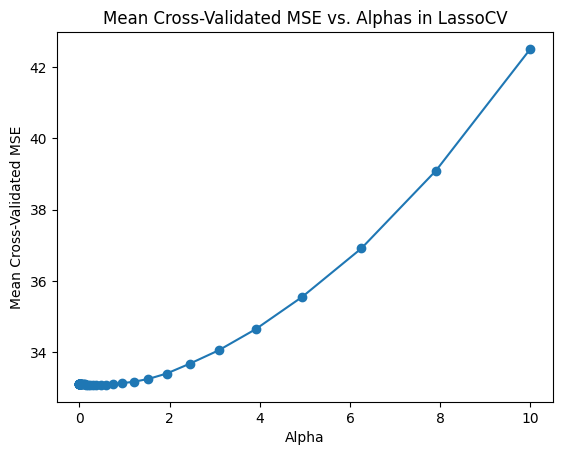

Chosen alpha (best): 0.3727593720314942
Coefficients of the model:
 [ 6.12015703e-01 -2.23627568e-03  1.74694405e-01  5.82751601e-01
  8.23908083e-02  4.86387660e-03 -3.15223181e-04  3.51066591e-03
  2.80870331e-02  0.00000000e+00 -1.04070758e-06 -1.69018573e-04
  6.55636478e-04 -4.69242593e-05 -1.49029274e-03 -1.33489221e-02
  2.51552267e-02 -2.13560938e-02 -1.54274782e-02  1.72193557e-02]
Intercept of the model: 14.81852586364354
Best score achieved: 0.18263083377633138


In [10]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas import read_csv
from matplotlib import pyplot
dataframe = read_csv("/content/data-reg.csv", header=None)

data = dataframe.values
X, y = data[:, :-1], data[:, -1]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_poly)

alphas = np.logspace(-4, 1, 50)
lasso_reg = LassoCV(cv=5, alphas=alphas, fit_intercept=True).fit(X_poly, y)
y_pred_lasso = lasso_reg.predict(X_standardized)


mse_path = lasso_reg.mse_path_
mean_mse = mse_path.mean(axis=1)

plt.plot(lasso_reg.alphas_, mean_mse, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Mean Cross-Validated MSE")
plt.title("Mean Cross-Validated MSE vs. Alphas in LassoCV")

plt.show()


print("Chosen alpha (best):", lasso_reg.alpha_)
#print("All alphas tested:", lasso_reg.alphas_)
#print("Mean squared error for each fold at each alpha:\n", mse_path)
#print("Number of iterations for each alpha:\n", lasso_reg.n_iter_)
print("Coefficients of the model:\n", lasso_reg.coef_)
print("Intercept of the model:", lasso_reg.intercept_)
print("Best score achieved:", lasso_reg.score(X_standardized, y))

# Softmax

In [13]:
import numpy as np

class SoftmaxRegression:
    def __init__(self, n_classes, learning_rate=0.1, n_iterations=1, mb =20):
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.mb = mb
        self.theta = None
        self.log_loss = []

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probabilities

    def compute_loss(self, X, y):
        logits = X.dot(self.theta)
        probabilities = self.softmax(logits)
        m = len(y)
        probabilities = np.clip(probabilities, 1e-15, 1 - 1e-15)
        log_likelihood = -np.log(probabilities[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss

    def fit(self, X, y, mb):
      m, n_features = X.shape
      self.theta = np.zeros((n_features, self.n_classes))
      log_loss = []
      for iteration in range(self.n_iterations):
          #Mesanje podataka na pocetku svake iteracije
          indices = np.random.permutation(m)
          X_shuffled = X[indices]
          y_shuffled = y[indices]

          for i in range(0, 1, self.mb): # Mogucnost dodavanja vise mini-sarzi po iteraciji
              X_batch = X_shuffled[i:i + mb]
              y_batch = y_shuffled[i:i + mb]
              logits = X_batch.dot(self.theta)
              probabilities = self.softmax(logits)

              # One-hot kodovanje klase za odabranu grupe podataka
              y_one_hot = np.zeros((X_batch.shape[0], self.n_classes))
              y_one_hot[np.arange(X_batch.shape[0]), y_batch] = 1

              # Racunanje gradijenta i popravka parametara
              gradient = X_batch.T.dot(probabilities - y_one_hot) / mb
              self.theta -= self.learning_rate * gradient

          self.log_loss.append(self.compute_loss(X, y))


    def predict(self, X):
        logits = X.dot(self.theta)
        probabilities = self.softmax(logits)
        return np.argmax(probabilities, axis=1)


Optimalna brzina ucenja: 0.4
Optimalna mini-sarza: 10


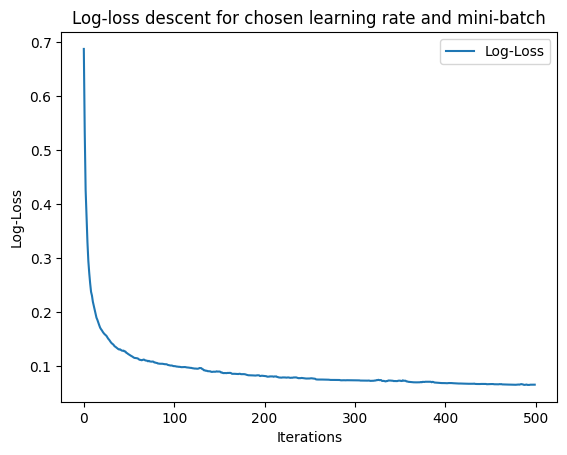

In [18]:
dataframe = read_csv("/content/data-class.csv", header=None)

validation_data = dataframe.sample(frac=0.3, random_state=1) # 30% podataka za validaciju
training_data = dataframe.drop(validation_data.index)

data_val = validation_data.values
X_val, y_val = data_val[:, :-1], data_val[:, -1]
y_val = y_val.astype(int)

data = training_data.values
X, y = data[:, :-1], data[:, -1]
y = y.astype(int)

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_val_standardized = scaler.transform(X_val)

mini_batch_size = 10
iterations = 500
learning_rate = 0.4
# Incijalizacija klase za softmax regresiju gde se podesava brzina ucenja, broj iteracija i velicina mini-sarze
model = SoftmaxRegression(n_classes=3, learning_rate=learning_rate, n_iterations=iterations, mb=mini_batch_size)
model.fit(X_standardized, y, mini_batch_size)

print(f"Optimalna brzina ucenja: {learning_rate}")
print(f"Optimalna mini-sarza: {mini_batch_size}")
plt.plot(range(iterations), model.log_loss, label="Log-Loss")
plt.xlabel("Iterations")
plt.ylabel("Log-Loss")
plt.title("Log-loss descent for chosen learning rate and mini-batch")
plt.legend()
plt.show()


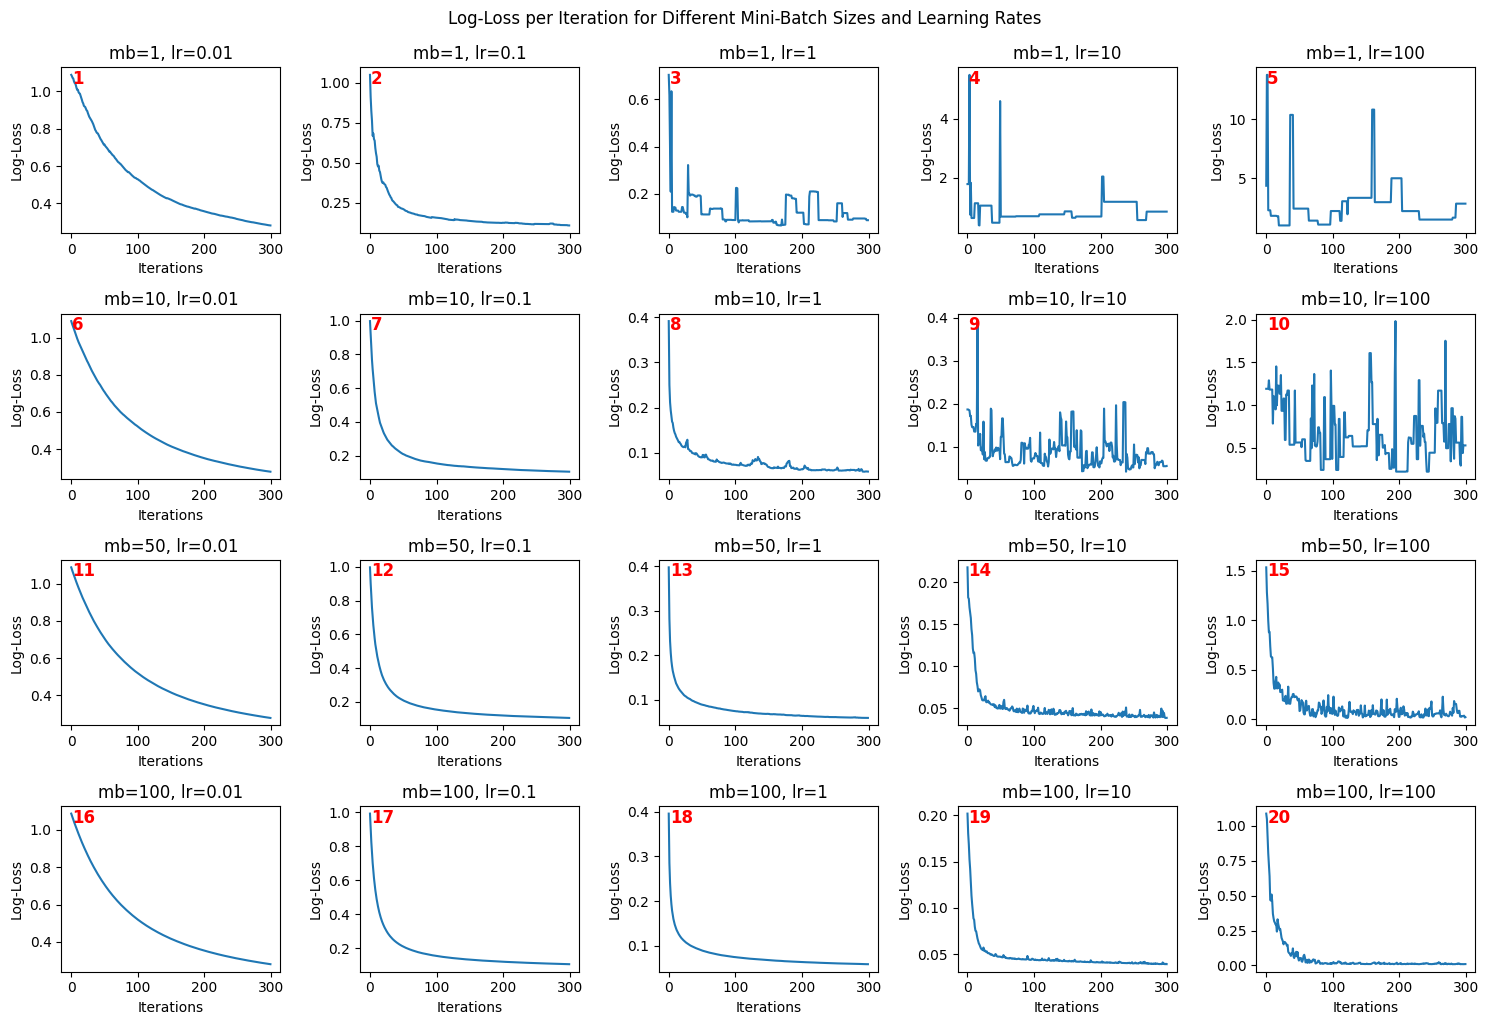

In [ ]:
# Parametri
mini_batch_sizes = [1, 10, 50, 100]
learning_rates = [0.01, 0.1, 1, 10, 100,]
iterations = 300

# convergence_results = []

# # Kriterijumi konvergencije
# convergence_threshold = 0.0001  # Maksimalan razlika funkcije gubitka izmedju dve iteracije
# consecutive_iterations = 10  # Broj uzastopnih iteracije gde je razlika manja od granice

# for i, mb in enumerate(mini_batch_sizes):
#     for j, lr in enumerate(learning_rates):
#         # Inicijalizacija i treniranje modela
#         model = SoftmaxRegression(n_classes=3, learning_rate=lr, n_iterations=iterations)
#         model.fit(X_standardized, y, mb)

#         # Relativna promena izmedja uzastopnih iteracija
#         log_loss_changes = np.abs(np.diff(model.log_loss) / model.log_loss[:-1])
#         converged_at_iteration = None

#         # Prolazak kroz listu zbog pronalaska konvergencije
#         for k in range(len(log_loss_changes) - consecutive_iterations + 1):
#             if np.all(log_loss_changes[k:k + consecutive_iterations] < convergence_threshold):
#               converged_at_iteration = k + consecutive_iterations
#               break

        # if converged_at_iteration is not None:
        #     print(f"Konvergencija detektovana. mb={mb}, lr={lr}, broj iteracije: {converged_at_iteration}")
        # else:
        #     print("Nije detektovana konvergencija na datom broju iteracija")

        # Ako je model konvergirao u datom broju iteracija
        # if converged_at_iteration is not None:
        #     convergence_results.append({
        #         'mb': mb,
        #         'lr': lr,
        #         'final_log_loss': model.log_loss[converged_at_iteration],
        #         'converged_at_iteration': converged_at_iteration
        #     })

# Sortirana lista najnize vrednosti kriterijumske funckije prilikom konvergencije
#sorted_results = sorted(convergence_results, key=lambda x: x['converged_at_iteration'])

# Odredjivanje najbrze konvergencije
# if sorted_results:
#     fastest_convergence = sorted_results[0]
#     print(f"Kombinacija koja najbrze konvergira: mini-batch={fastest_convergence['mb']}, "
#           f"Brzina ucenje={fastest_convergence['lr']}, "
#           f"Konacni log-loss={fastest_convergence['final_log_loss']:.4f}, "
#           f"Konvergiralo posle {fastest_convergence['converged_at_iteration']} iteracija")


plt.figure(figsize=(15, 10))

for i, mb in enumerate(mini_batch_sizes):
    for j, lr in enumerate(learning_rates):

        model = SoftmaxRegression(n_classes=3, learning_rate=lr, n_iterations=iterations)
        model.fit(X_standardized, y, mb)

        # Calculate subplot index and add plot
        plot_index = i * len(learning_rates) + j + 1
        plt.subplot(len(mini_batch_sizes), len(learning_rates), plot_index)

        # Plot log-loss curve
        plt.plot(range(iterations), model.log_loss)
        plt.xlabel("Iterations")
        plt.ylabel("Log-Loss")
        plt.title(f"mb={mb}, lr={lr}")

        # Add reference number to top-left of each subplot
        plt.text(0.05, 0.9, f"{plot_index}", transform=plt.gca().transAxes,
                 fontsize=12, fontweight='bold', color="red")

plt.tight_layout()
plt.suptitle("Log-Loss per Iteration for Different Mini-Batch Sizes and Learning Rates", y=1.02)
plt.show()




Optimalni parametri su:  
mb (mini-sarza) ~ 10  
lr (brzina ucenja) ~ 0.5   
Sa deset primera po iteraciji algoritam je brz. Brzina ucenja od 0.5 je dovoljno mala da se pogodi minimum funkcije ali i dovoljno velika za brzu konvergenciju.  
  
Primeri koji imaju optimalni broj primera u mini-sarzi ali peveliku brzinu ucenja su grafici 9 i 10. Prevelika brzina ucenja sa malim brojema primera dovodi da preskakanja minimuma i unosi dosta 'buke'. Obrnuto, grafik 11, zbog male brzine ucenja algoritam sporo konvergira.  
  
Primeri koji imaju optimalnu brzinu ucenja ali premali broj primera u mini sarzi je grafik broj 3. Zbog malog broja primera, algoritmu je tesko da pogodi pravi smer kretanja i zbog toga postoje "skokovi". Sa druge strane, ne postoji preveliki broj primera u mini-sarzi. Potrebno je uzeti minimalan broj da bi putanja smanjenja fukncija bila glatka ali sto brza.